In [1]:
import os, cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 

from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout, Reshape
from keras.optimizers import Adam
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.callbacks import EarlyStopping

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Conv2DTranspose

from timeit import default_timer as timer

2024-04-22 15:53:13.542927: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 15:53:13.547282: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 15:53:13.601472: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 15:53:14.875755: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# initialize file paths
cwd = f"{os.getcwd()}/"
image_folder_path = f"{cwd}data/Images/"
labels_path = f"{cwd}data/Pixel_masks/"
bboxes_csv_path = f"{cwd}PCB_annotations_dataset.csv"
# initialize image list
image_filenames = os.listdir(image_folder_path)
bounding_boxes_data = pd.read_csv(bboxes_csv_path, sep=";")

In [3]:

grouped_bbox = bounding_boxes_data.groupby('filename')

image_data = []
class_labels = []
mask_data= []

for filename in image_filenames:
    image_path = os.path.join(image_folder_path, filename)
    
    image = cv2.imread(image_path)
    image = cv2.resize(image, (600, 600))  
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_array = np.asarray(gray_image) / 255.0 
    image_data.append(image_array)

    filename = os.path.splitext(filename)[0]
        
    mask = np.zeros((600, 600), dtype=np.uint8)

    if filename in grouped_bbox.groups:
        image_bbox_df = grouped_bbox.get_group(filename)

        for index, row in image_bbox_df.iterrows():
            class_label = row['defect']
           
            xmin, ymin, xmax, ymax = [int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])] 
            mask[ymin:ymax, xmin:xmax] = 255 
    
    mask = np.asarray(mask) / 255.0

    mask_array = np.asarray(mask)
            
    mask_data.append(mask_array)
    
    class_labels.append(class_label)

X_images = np.asarray(image_data)
y_bounding_boxes = np.asarray(mask_data)
y_class_labels = np.asarray(class_labels)

encoder = LabelEncoder()

y_class_labels_encoded = encoder.fit_transform(y_class_labels)
y_categorical = to_categorical(y_class_labels_encoded)

label_mapping = {index: label for index, label in enumerate(encoder.classes_)}

In [4]:
new_size = (100, 100)

cropped_images = []
cropped_masks = []
cropped_y_categorical = []
for image, mask, labels in zip(X_images, y_bounding_boxes, y_categorical):
    for y in range(0, 600, 100):
        for x in range(0, 600, 100):
            y0, x0 = y, x
            y100, x100 = y+100, x+100
            # if a bounding box crosses the cropping border, increase shift the corresponding border, so defects are not cut off
            while( np.any(mask[y0, x0:x100])) and (y0 != 0): 
                y0 -= 1
            while (np.any(mask[min(y100, 599), x0:x100])) and (y100 != 600):
                y100 += 1
            while( np.any(mask[y0:y100, x0])) and (x0 != 0):
                x0 -= 1
            while( np.any(mask[y0:y100, min(x100, 599)])) and (x100 != 600):
                x100 += 1
            patch_image = cv2.resize(image[y0:y100, x0:x100], (100, 100))
            patch_mask = cv2.resize(mask[y0:y100, x0:x100], (100, 100))
            if np.any(patch_mask):
                cropped_images.append(patch_image)
                cropped_masks.append(patch_mask)
                cropped_y_categorical.append(labels)

cropped_images = np.array(cropped_images)
cropped_masks = np.array(cropped_masks)
cropped_y_categorical = np.array(cropped_y_categorical)

In [ ]:
nr = np.random.choice(cropped_images.shape[0], 10, replace=False)
for i in range(10):
    img = cropped_images[nr[i]]
    msk = cropped_masks[nr[i]]
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img)
    ax[1].imshow(msk)


In [6]:
print(X_images.shape)
print(y_bounding_boxes.shape)
print(cropped_images.shape)
print(cropped_masks.shape)
print(cropped_y_categorical.shape)

(200, 600, 600)
(200, 600, 600)
(635, 100, 100)
(635, 100, 100)
(635, 2)


In [7]:
# Split data into train and validation sets
X_train, X_test, y_train_bbox, y_test_bbox, y_train_categorical, y_test_categorical = train_test_split(cropped_images, cropped_masks, cropped_y_categorical, 
                                                                                                      test_size=0.2, random_state=42)

In [8]:
print("X_train shape:", X_train.shape)
print("y_train_bbox shape:", y_train_bbox.shape)
print("y_train_categorical shape:", y_train_categorical.shape)
print("X_test shape:", X_test.shape)
print("y_test_bbox shape:", y_test_bbox.shape)
print("y_test_categorical shape:", y_test_categorical.shape)

X_train shape: (508, 100, 100)
y_train_bbox shape: (508, 100, 100)
y_train_categorical shape: (508, 2)
X_test shape: (127, 100, 100)
y_test_bbox shape: (127, 100, 100)
y_test_categorical shape: (127, 2)


In [9]:
# Data Augmentation:
# rotation ,width_shift, height_shift, shear, zoom, horizontal_flip

def augment_data(images, masks, labels):
    augmented_images = []
    augmented_masks = []
    augmented_labels = []

    for image, mask, label in zip(images, masks, labels):
        augmented_images.append(image)
        augmented_masks.append(mask)
        augmented_labels.append(label)

        shear_image, shear_mask = shear(image, mask)
        augmented_images.append(shear_image)
        augmented_masks.append(shear_mask)
        augmented_labels.append(label)
        # print("Shear:", shear_image.shape, shear_mask.shape)

        flip_image, flip_mask = flip(image, mask)
        augmented_images.append(flip_image)
        augmented_masks.append(flip_mask)
        augmented_labels.append(label)
        # print("Flip:", flip_image.shape, flip_mask.shape)

        zoom_image, zoom_mask = zoom(image, mask)
        augmented_images.append(zoom_image)
        augmented_masks.append(zoom_mask)
        augmented_labels.append(label)
        # print("Zoom:", zoom_image.shape, zoom_mask.shape)

        width_shift_image, width_shift_mask = width_shift(image, mask)
        augmented_images.append(width_shift_image)
        augmented_masks.append(width_shift_mask)
        augmented_labels.append(label)
        # print("Width Shift:", width_shift_image.shape, width_shift_mask.shape)

        height_shift_image, height_shift_mask = height_shift(image, mask)
        augmented_images.append(height_shift_image)
        augmented_masks.append(height_shift_mask)
        augmented_labels.append(label)
        # print("Height Shift:", height_shift_image.shape, height_shift_mask.shape)

        rotate_image, rotate_mask = rotate(image, mask)
        augmented_images.append(rotate_image)
        augmented_masks.append(rotate_mask)
        augmented_labels.append(label)
        # print("Rotation:", rotate_image.shape, rotate_mask.shape)

    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)
    augmented_labels = np.array(augmented_labels)

    return augmented_images, augmented_masks, augmented_labels

def shear(image, mask):
    shear_factor = np.random.uniform(-0.2, 0.2)
    rows, cols = image.shape[:2]
    shear_matrix = np.float32([[1, shear_factor, 0], [0, 1, 0]])
    shear_image = cv2.warpAffine(image, shear_matrix, (cols, rows))
    shear_mask = cv2.warpAffine(mask, shear_matrix, (cols, rows))

    padded_image = np.zeros((100, 100), dtype=np.uint8)
    padded_mask = np.zeros((100, 100), dtype=np.uint8)
    padded_image[:rows, :cols] = shear_image
    padded_mask[:rows, :cols] = mask

    return shear_image, shear_mask

def flip(image, mask):
    flip_image = cv2.flip(image, 1)
    flip_mask = cv2.flip(mask, 1)
    return flip_image, flip_mask

def zoom(image, mask):
    zoom_factor = np.random.uniform(0.8, 1.2)
    zoomed_image = cv2.resize(image, None, fx=zoom_factor, fy=zoom_factor)
    zoomed_mask = cv2.resize(mask, None, fx=zoom_factor, fy=zoom_factor)

    rows, cols = zoomed_image.shape[:2]
    if rows < 100 or cols < 100:
        pad_rows = max(0, (100 - rows) // 2)
        pad_cols = max(0, (100 - cols) // 2)
        zoomed_image = cv2.copyMakeBorder(zoomed_image, pad_rows, 100 - rows - pad_rows, pad_cols, 100 - cols - pad_cols, cv2.BORDER_CONSTANT, value=0)
        zoomed_mask = cv2.copyMakeBorder(zoomed_mask, pad_rows, 100 - rows - pad_rows, pad_cols, 100 - cols - pad_cols, cv2.BORDER_CONSTANT, value=0)
    elif rows > 100 or cols > 100:
        zoomed_image = zoomed_image[:100, :100]
        zoomed_mask = zoomed_mask[:100, :100]

    return zoomed_image, zoomed_mask

def width_shift(image, mask):
    shift_x = np.random.uniform(-0.2, 0.2) * image.shape[1]
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, 0]])
    width_shift_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    width_shift_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))

    if width_shift_image.shape[1] > 100:
        width_shift_image = width_shift_image[:, :100]
        width_shift_mask = width_shift_mask[:, :100]
    elif width_shift_image.shape[1] < 100:
        pad_width = 100 - width_shift_image.shape[1]
        width_shift_image = np.pad(width_shift_image, ((0, 0), (0, pad_width), (0, 0)), mode='constant')
        width_shift_mask = np.pad(width_shift_mask, ((0, 0), (0, pad_width), (0, 0)), mode='constant')

    return width_shift_image, width_shift_mask

def height_shift(image, mask):
    shift_y = np.random.uniform(-0.2, 0.2) * image.shape[0]
    translation_matrix = np.float32([[1, 0, 0], [0, 1, shift_y]])
    height_shift_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    height_shift_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))

    if height_shift_image.shape[0] > 100:
        height_shift_image = height_shift_image[:100, :]
        height_shift_mask = height_shift_mask[:100, :]
    elif height_shift_image.shape[0] < 100:
        pad_height = 100 - height_shift_image.shape[0]
        height_shift_image = np.pad(height_shift_image, ((0, pad_height), (0, 0), (0, 0)), mode='constant')
        height_shift_mask = np.pad(height_shift_mask, ((0, pad_height), (0, 0), (0, 0)), mode='constant')

    return height_shift_image, height_shift_mask

def rotate(image, mask):
    angle = np.random.uniform(-20, 20)
    rows, cols = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotate_image = cv2.warpAffine(image, rotation_matrix, (cols, rows))
    rotate_mask = cv2.warpAffine(mask, rotation_matrix, (cols, rows))

    if rotate_image.shape[0] > 100 or rotate_image.shape[1] > 100:
        rotate_image = cv2.resize(rotate_image, (100, 100))
        rotate_mask = cv2.resize(rotate_mask, (100, 100))
    elif rotate_image.shape[0] < 100 or rotate_image.shape[1] < 100:
        pad_height = max(0, 100 - rotate_image.shape[0])
        pad_width = max(0, 100 - rotate_image.shape[1])
        rotate_image = np.pad(rotate_image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')
        rotate_mask = np.pad(rotate_mask, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')

    return rotate_image, rotate_mask


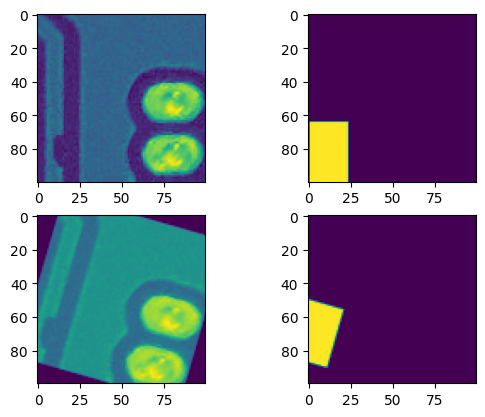

In [11]:
nr = np.random.choice(X_train.shape[0])
img = X_train[nr]
msk = y_train_bbox[nr]
img_tr, msk_tr = rotate(img, msk)
fig, ax = plt.subplots(2,2)
ax[0][0].imshow(img)
ax[0][1].imshow(msk)
ax[1][0].imshow(img_tr)
ax[1][1].imshow(msk_tr)


In [10]:
X_train_augmented, y_train_augmented, y_train_categorical_augmented = augment_data(X_train, y_train_bbox, y_train_categorical)

In [11]:
print("X_train shape:", X_train.shape)
print("y_train_bbox shape:", y_train_bbox.shape)
print("y_train_categorical shape:", y_train_categorical.shape)

print("X_train_augmented shape:", X_train_augmented.shape)
print("y_train_augmented shape:", y_train_augmented.shape)
print("y_train_categorical_augmented shape:", y_train_categorical_augmented.shape)

X_train shape: (508, 100, 100)
y_train_bbox shape: (508, 100, 100)
y_train_categorical shape: (508, 2)
X_train_augmented shape: (3556, 100, 100)
y_train_augmented shape: (3556, 100, 100)
y_train_categorical_augmented shape: (3556, 2)


In [12]:
# Combining images and masks into tuples
combined_data = list(zip(X_train_augmented, y_train_augmented, y_train_categorical_augmented))

# Shuffle the dataset
np.random.shuffle(combined_data)


Batch of images shape: (14924, 100, 100)
Batch of labels shape: (14924, 100, 100)
Batch of labels shape: (14924, 6)
Labels: [0. 0. 0. 0. 0. 1.]
Integer label: spurious_copper


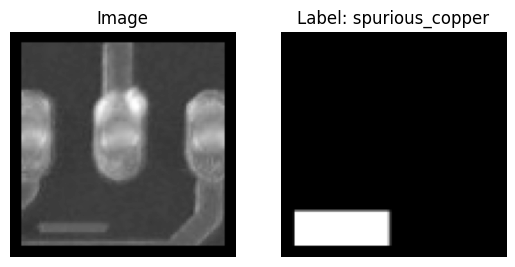

In [15]:
# plt.imshow(train_dataset)
# i=92

class_labels = {}
label_tuples = []
no_defects = 6
for k in range(no_defects):
    #label_tuples.append(tuple(1 if i == k else 0 for i in range(6)))
    label_tuples.append(tuple(1 if i == k else 0 for i in range(no_defects)))
defect_names = ['missing_hole', 'mouse_bite', 'open_circuit', 'short', 'spur','spurious_copper']
#defect_names = ['short']
for key, value in zip(label_tuples, defect_names):
    class_labels[key] = value

def label_to_int(label):
    return class_labels[tuple(label)]

np.random.shuffle(combined_data)

for images, masks, labels in combined_data:
    print("Batch of images shape:", X_train_augmented.shape)
    print("Batch of labels shape:", y_train_augmented.shape)
    print("Batch of labels shape:", y_train_categorical_augmented.shape)
    print("Labels:", labels)
    
    plt.subplot(1, 2, 1)
    plt.imshow(images.squeeze(), cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks.squeeze(), cmap='gray')

    conv_label = label_to_int(labels)
    print("Integer label:", conv_label)
    plt.title(f'Label: {conv_label}') 

    plt.axis('off')
    plt.show()

    break 

In [13]:
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [14]:
early_stopping = EarlyStopping(
                                patience=2, 
                                min_delta = 0.005, 
                                verbose=1,
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, 
                                    episilon= 0.01,
                                    factor=0.1,  
                                    cooldown = 2, 
                                    verbose=1)

time_callback = TimingCallback()


In [15]:
def enhanced_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(32, 5, activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottom
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)

    # Decoder
    up1 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv3)
    up1 = layers.concatenate([up1, conv2], axis=3)
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(up1)

    up2 = layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv4)
    up2 = layers.concatenate([up2, conv1], axis=3)
    conv5 = layers.Conv2D(32, 5, activation='relu', padding='same')(up2)

        # Output
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [16]:
# Instantiate the model
model = enhanced_unet(input_shape=(100, 100, 1))

In [17]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy', 'mae'])  

In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 100,  │        832 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 50, 50,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 50, 50,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 25, 25,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 25, 25,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 50, 50,    │     32,832 │ conv2d_2[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 50, 50,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 50, 50,    │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 100, 100,  │      8,224 │ conv2d_3[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100, 100,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 100, 100,  │     51,232 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 100, 100,  │         33 │ conv2d_4[0][0]    │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 259,297 (1012.88 KB)

 Trainable params: 259,297 (1012.88 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.utils import plot_model
import pydot
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True);

In [20]:
print("X_train_augmented shape:", X_train_augmented.shape)
print("y_train_augmented shape:", y_train_augmented.shape)
print("y_train_categorical_augmented shape:", y_train_categorical_augmented.shape)
print("Expected input shape for the model:", model.input_shape)

print("Model output shape:", model.output_shape)

print("Data type of y_train_augmented:", y_train_augmented.dtype)

X_train_augmented shape: (3556, 100, 100)
y_train_augmented shape: (3556, 100, 100)
y_train_categorical_augmented shape: (3556, 2)
Expected input shape for the model: (None, 100, 100, 1)
Model output shape: (None, 100, 100, 1)
Data type of y_train_augmented: float64


In [21]:
# Train the model
history = model.fit(x=X_train_augmented, 
                    y=y_train_augmented,
                    epochs=16,
                    batch_size=32,
                    validation_data=(X_test, y_test_bbox),
                    callbacks=[reduce_learning_rate, time_callback],
                    verbose=True)

Epoch 1/16
112/112 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.8920 - loss: 0.3453 - mae: 0.2030 - val_accuracy: 0.9234 - val_loss: 0.2664 - val_mae: 0.1091 - learning_rate: 0.0010
Epoch 2/16
112/112 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.9234 - loss: 0.2501 - mae: 0.1306 - val_accuracy: 0.9234 - val_loss: 0.2505 - val_mae: 0.1487 - learning_rate: 0.0010
Epoch 3/16
112/112 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.9240 - loss: 0.2380 - mae: 0.1281 - val_accuracy: 0.9234 - val_loss: 0.2319 - val_mae: 0.1277 - learning_rate: 0.0010
Epoch 4/16
112/112 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.9246 - loss: 0.2237 - mae: 0.1194 - val_accuracy: 0.9341 - val_loss: 0.2056 - val_mae: 0.0991 - learning_rate: 0.0010
Epoch 5/16
112/112 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.9321 - loss: 0.2061 - mae: 0.1091 - val_accuracy: 0.9422 - val_loss: 0.1888 - val_mae: 0.1199 - learning_rate: 0.0010
Epoch 6/16
112/112 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.9401 - l

In [22]:
saved_model = model.save('model_unet_trained_on_2x100.keras')
history_df = pd.DataFrame(history.history)
history_df.to_csv('model_unet_training_history_on_2x100.csv', index=False)

In [23]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

train_mae = history.history["mae"]
val_mae = history.history["val_mae"]


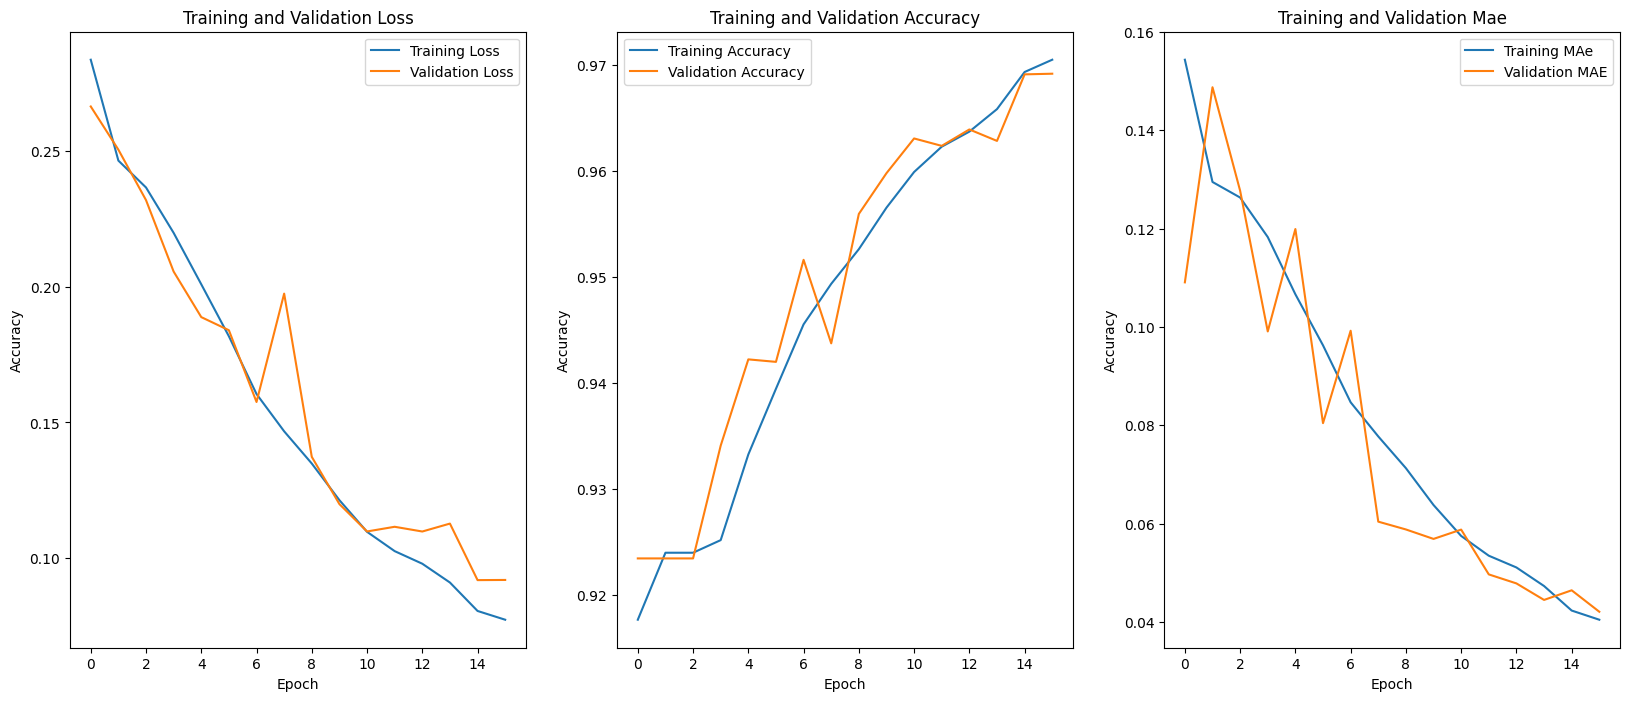

In [24]:

plt.figure(figsize = (20, 8))

plt.subplot(131)
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(132)
plt.plot(train_acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.subplot(133)
plt.plot(train_mae, label="Training MAe")
plt.plot(val_mae, label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Mae")
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


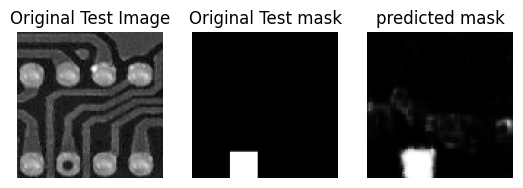

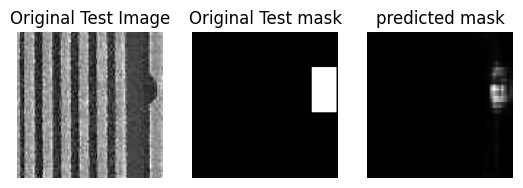

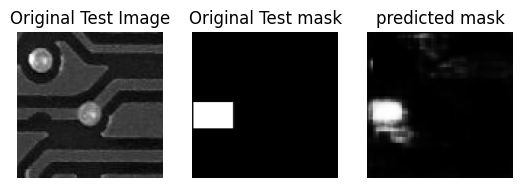

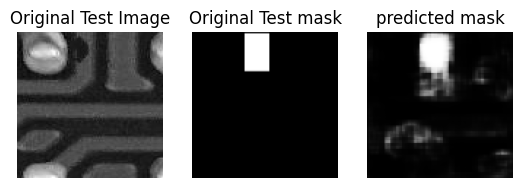

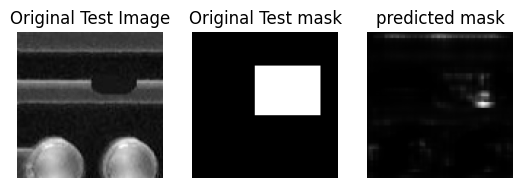

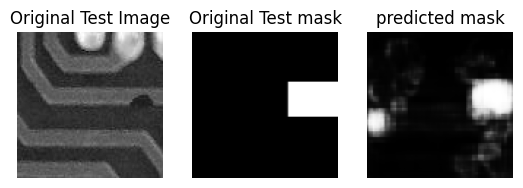

In [26]:
y_val_pred = model.predict(X_test)

for i in np.random.choice(X_test.shape[0], replace=False, size=6):

    plt.subplot(131) 
    plt.imshow(X_test[i].squeeze(), cmap='gray')  
    plt.title('Original Test Image')
    plt.axis('off')

    plt.subplot(132)  
    plt.imshow(y_test_bbox[i].squeeze(), cmap='gray') 
    plt.title('Original Test mask')
    plt.axis('off')

    plt.subplot(133)  
    plt.imshow(y_val_pred[i].squeeze(), cmap='gray')  
    plt.title('predicted mask')
    plt.axis('off')

    plt.show()
    